In [11]:
import sys
sys.path.append('../src')

import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot as gplt
import numpy as np
from glob import glob
import pandas as pd
from joblib import Parallel, delayed
from IPython.display import Markdown, display

from geoq import geom
from geoq import gemini
world = geom.get_world()

## read all text embeddings

In [2]:
files = glob('/datasets/genai-geo-embeddings/chips/*')
def readf(fname):
    with open(fname, 'rb') as f:
        z = pickle.load(f)
        
    return {k: z[k] for k in ['chip_id', 'text_embedding', 'lonlat']}

embs = Parallel(verbose=5, n_jobs=-1)(delayed(readf)(fname) for fname in files)
embs = pd.DataFrame(embs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 777 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1409 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 2592 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 4664 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 8248 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 15392 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 23168 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 31520 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 40448 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 44852 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 45512 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 46178 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 46880 ta

## create an array with all vectors for searching

In [3]:
vdb = np.r_[[np.r_[i] for i in embs.text_embedding.values]]
vdb.shape

(48313, 3072)

In [4]:
embs.head()

,chip_id,text_embedding,lonlat
0,095cfcd323303,"[-0.01660313, 0.012049381, 0.0010464485, -0.09...","(91.34310709799735, 50.41987022773517)"
1,1de2ec148d69e,"[0.00019912038, 0.0006002876, 0.0023643174, -0...","(-64.27066308931353, -31.05902171821698)"
2,0390ba50042b7,"[-0.005758315, 0.013372932, -0.0065198652, -0....","(88.88300854819661, 33.096023502661836)"
3,006c8f2f97054,"[-0.0034016648, 0.009198167, 0.0032611303, -0....","(-69.98211629173304, -28.85582200279133)"
4,133a7a94508ae,"[0.0066798693, -0.0077378256, 0.0057974225, -0...","(76.68477394326017, 10.599668934745567)"


## make a query by comparing the query embeddings with all chips embeddings

In [5]:
gem = gemini.GeminiMultimodalModel(api_key='../../secrets/gemini.txt', verbose=True)


2025-08-10 22:51:29.427 | INFO     | geoq.gemini:__init__:115 - using generation model gemini-2.5-pro
2025-08-10 22:51:29.428 | INFO     | geoq.gemini:__init__:116 - using embeddings model gemini-embedding-001
2025-08-10 22:51:29.429 | INFO     | geoq.gemini:__init__:117 - using config {'temperature': 1, 'top_p': 0.95, 'max_output_tokens': 8192, 'response_mime_type': 'text/plain'}


In [36]:
q = 'rivers'
q = 'show me places with large crop fields'
q = 'show me places with circular crop fields'
q = 'rivers through cities'
q = 'rivers in South America'
q = 'where do camels live?'
q = 'show me beaches near by cities'
q = 'show me large wide beaches'
q = 'show me beaches near by mountains'
q = 'places with curvy roads'
q = 'places with straight roads'
q = 'urban areas in Colombia'
q = 'fiords'
q = 'glaciars'
q = 'very narrow valleys with a river'
q = 'football stadiums'
q = 'bridges'
q = 'olive trees'
q = 'sugar cane plantations'
q = 'coastal roads in Central America'
q = 'coastal roads in Southern Europe'

qe = gem.get_embedding(q)

## get the top 10 most similar

In [37]:
distances = np.sum((vdb - qe)**2, axis=1)
topn_idxs = np.argsort(distances)[:10]

In [38]:
topn = embs.iloc[topn_idxs].copy()
topn['distance'] = distances[topn_idxs]
topn

,chip_id,text_embedding,lonlat,distance
9432,0e85a239d2dd0,"[-0.0035831833, 0.012440308, -0.009587219, -0....","(5.51219809857971, 43.22277568075987)",0.456331
29089,07a5508528f2f,"[-0.0119088935, 0.007077604, -0.015121708, -0....","(17.328397401715577, 43.11274047811543)",0.469078
16195,276d7aaba647b,"[-0.0054254443, 0.012802407, -0.003496099, -0....","(7.579647625658304, 43.77427107121199)",0.476808
32367,13d9a244c0648,"[0.0002468269, 0.015404708, -0.013989264, -0.0...","(-4.63933952799475, 36.57475361931457)",0.482756
37393,1149f907c0047,"[-0.006290823, 0.004733851, -0.007914392, -0.1...","(16.807574501460397, 40.309218285944574)",0.484576
10293,34482c17e5e0a,"[-0.0010816128, -0.0011206139, -0.0018089942, ...","(18.607490240828245, 42.38802128277522)",0.485200
5621,2f812c1271d71,"[-0.019549731, -0.0002544971, -0.016140895, -0...","(31.9888240098634, 36.521227926081)",0.489309
25491,36b76bcd53b71,"[-0.009571152, 0.005612377, -0.00916296, -0.10...","(24.23217974409649, 38.33610473142296)",0.490912
14123,13c26339c50b1,"[0.0011293486, 0.010065414, -0.004392873, -0.1...","(32.5061004203937, 36.10906363291538)",0.491715
13540,13835408bd496,"[0.0039199004, 0.008532813, -0.013360897, -0.0...","(23.01752021367261, 36.748340193461246)",0.491994


## User query: **coastal roads in Southern Europe**

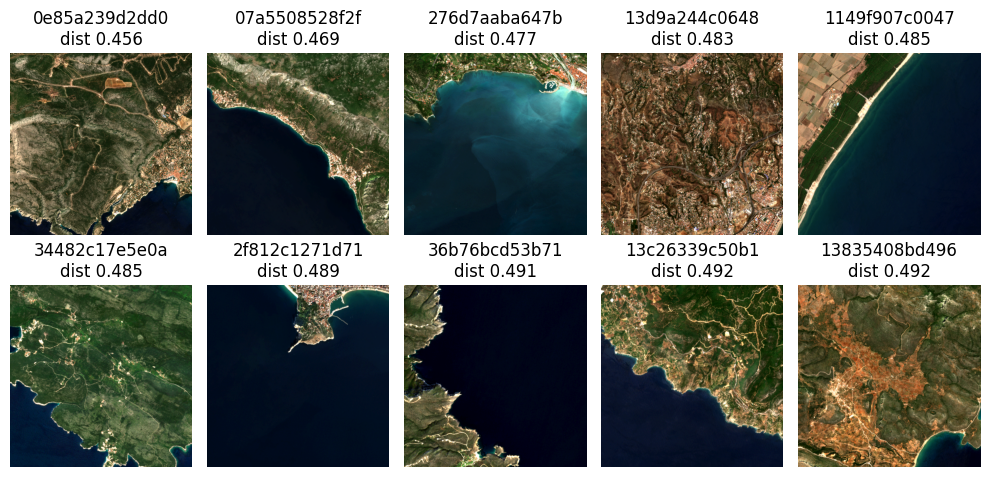

In [43]:
display(Markdown(f'## User query: **{q}**'))

fig = plt.figure(figsize=(10,5))
axs = fig.subplots(2,5).flatten()

for i, (_, ti) in enumerate(topn.iterrows()):
    file = files[ti.name]
    ax = axs[i]

    # sanity check, chip id must be the same as file if
    assert file.split('/')[-1].split('.')[0] == ti.chip_id

    with open(file, 'rb') as f:
        z = pickle.load(f)    

    ax.imshow(z['img'])
    ax.set_axis_off()

    ax.set_title(f'{ti.chip_id}\ndist {ti.distance:0.3f}')
    
fig.tight_layout()

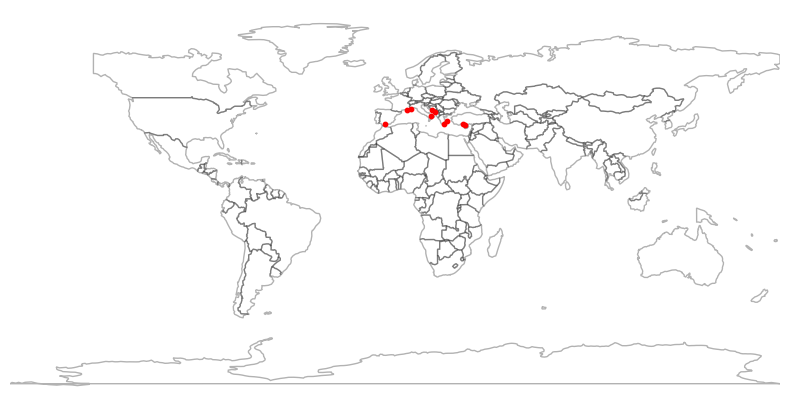

In [44]:
lonlats = np.r_[[np.r_[i] for i in topn.lonlat.values]]

ax = plt.figure(figsize=(10,5)).subplots(1,1)
gplt.polyplot(world, alpha=0.3,  ax=ax)
plt.scatter(lonlats[:,0], lonlats[:,1], color='red', alpha=1, s=10)